# Data Preparation, Pipelines & Model 

In [91]:
# Modules importeren
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
import joblib

In [92]:
# Dataset importeren 
df = pd.read_csv("/Users/odessa/Desktop/Applied Data Science & AI/Data Science/Code Inleiding data science/song_data.csv")

In [93]:
# Target variabele maken 
target = 'song_popularity'

### Phase 3: Data Preparation

In [94]:
# 2 nummers droppen
df = df.drop([7119, 11171]).reset_index(drop=True)

In [95]:
print(f"Totaal aantal waardes in de dataframe vóór het verwijderen van dubbele waardes uit song_name en song_duration_ms: {len(df)}")

# Dubbele waardes droppen van song_name en song_duration 
# Als ik alleen song_name duplicates zou verwijderen, zou ik misschien covers van nummers verwijderen, dus daarom check ik ook de song_duration 
df.drop_duplicates(subset=['song_name', 'song_duration_ms'], inplace = True)
print(f"Totaal aantal waardes in de dataframe na verwijderen van dubbele waardes uit song_name en song_duration_ms: {len(df)}")

Totaal aantal waardes in de dataframe vóór het verwijderen van dubbele waardes uit song_name en song_duration_ms: 18833
Totaal aantal waardes in de dataframe na verwijderen van dubbele waardes uit song_name en song_duration_ms: 14466


In [96]:
df.drop(columns=["song_name"], inplace=True) # inplace=True veranderd de originele dataframe zonder nieuwe dataframe te maken 

In [97]:
X = df.drop(columns=[target], axis=1)
y = df[target]

In [98]:
# Zorg dat 'key' en 'time_signature' als categorisch gezien worden
X['time_signature'] = X['time_signature'].astype(str)
X['key'] = X['key'].astype(int)  # blijft numeriek voor de cyclische encoder

## Winsorizer Class

In [99]:
# BaseEstimator zorgt dat sklearn mijn class kan herkennen als model/stap in pipeline.
# TransformerMixin geeft .fit_transform().
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, kolommen): 
        self.kolommen = kolommen 
        self.grenzen_ = None # '_' betekent dat het attribuut pas beschikbaar wordt, nadat fit() is uitgevoerd. 
                             # None, omdat de grenzen nog niet bestaan -- worden berekend bij fit().

    def fit(self, X, y=None):
        """Bereken de onder- en bovengrenzen per kolom met interkwartielafstand-regel."""
        self.grenzen_ = {}
        for kolom in self.kolommen:
            Q1 = X[kolom].quantile(0.25)
            Q3 = X[kolom].quantile(0.75)
            IKR = Q3 - Q1 
            ondergrens = Q1 - 1.5 * IKR
            bovengrens = Q3 + 1.5 * IKR
            self.grenzen_[kolom] = (ondergrens, bovengrens)
        return self 
    
    def transform(self, X):
        """Winsoriseer uitschieters: vervang alle waardes buiten de grenzen met de dichtstbijzijnde grenswaarde."""
        X = X.copy() # kopie maken van data
        for kolom, (ondergrens, bovengrens) in self.grenzen_.items():
            dtype = X[kolom].dtype

            # If the column is integer, cast the thresholds first
            if np.issubdtype(dtype, np.integer):
                ondergrens = int(round(ondergrens))
                bovengrens = int(round(bovengrens))

            X.loc[X[kolom] < ondergrens, kolom] = ondergrens
            X.loc[X[kolom] > bovengrens, kolom] = bovengrens

            # Just to be sure, cast back to the original dtype
            X[kolom] = X[kolom].astype(dtype)
        return X
    
    def get_feature_names_out(self, input_features=None):
        """Zorg dat de kolomnamen behouden blijven in de pipeline."""
        return np.array(self.kolommen)

## Key Cyclic Encoder class 

In [100]:
class ToonsoortCyclischeEncoder(BaseEstimator, TransformerMixin):
    """
    Cyclisch encoden van de toonsoort/key (0-11) met sinus en cosinus. 
    """

    def __init__(self, kolom='key', max_waarde=12):
        self.kolom = kolom
        self.max_waarde = max_waarde
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X):
        X = X.copy()
        k = X[self.kolom]
        X[f'{self.kolom}_sin'] = np.sin(2 * np.pi * k/self.max_waarde)
        X[f'{self.kolom}_cos'] = np.cos(2 * np.pi * k/self.max_waarde)
        return X.drop(columns=[self.kolom])
    
    def get_feature_names_out(self, input_features=None):
        return np.array([f'{self.kolom}_sin', f'{self.kolom}_cos'])


In [101]:
def get_feature_names_from_column_transformer(ct):
    """Haalt feature names uit een ColumnTransformer, ook als nested pipelines aanwezig zijn."""
    output_features = []

    for name, transformer, cols in ct.transformers_:
        if transformer == 'drop':
            continue
        elif transformer == 'passthrough':
            output_features.extend(cols)
        elif hasattr(transformer, 'get_feature_names_out'):
            try:
                names = transformer.get_feature_names_out(cols)
                output_features.extend(names)
            except:
                output_features.extend(cols)
        elif hasattr(transformer, 'transformers_'):  # nested ColumnTransformer
            output_features.extend(get_feature_names_from_column_transformer(transformer))
        elif isinstance(transformer, Pipeline):
            last_step = transformer.steps[-1][1]
            if hasattr(last_step, 'get_feature_names_out'):
                try:
                    names = last_step.get_feature_names_out(cols)
                    output_features.extend(names)
                except:
                    output_features.extend(cols)
            else:
                output_features.extend(cols)
        else:
            output_features.extend(cols)
    return output_features


### Phase 4: Modeling 

Supervised learning, omdat je de uitkomst al hebt 
<br>
Supervised learning heeft 2 hoofdtakken: regressie en classificatie 
<br>
RMSE 
<br>
Meervoudige lineare regressie 
<br>
Logistieke lineare regressie is classification 
<br>
Random forests is het begin van dat machine learning slim werd 

In [102]:
def nieuwe_features(X):
    X = X.copy()
    X['energy_dance'] = X['energy'] * X['danceability']
    X['tempo_loudness'] = X['tempo'] * X['loudness']
    X['valence_energy'] = X['audio_valence'] * X['energy']
    X['acoustic_energy_ratio'] = X['acousticness'] / (X['energy'] + 0.001)
    X['speech_loudness_ratio'] = X['speechiness'] / (abs(X['loudness']) + 0.001)
    X['acoustic_dance_ratio'] = X['acousticness'] / (X['danceability'] + 0.001)
    X['energy_per_tempo'] = X['energy'] / (X['tempo'] + 0.001)
    X['valence_dance'] = X['audio_valence'] * X['danceability']
    X['duration_energy_ratio'] = X['song_duration_ms'] / (X['energy'] + 0.001)

    # Niet - lineaire verbanden 
    X['energy_sq'] = X['energy'] ** 2
    X['tempo_log'] = np.log1p(X['tempo'])
    X['loudness_sq'] = X['loudness'] ** 2
    return X
feature_engineering = FunctionTransformer(nieuwe_features, validate=False)

In [103]:
# Train en test set maken 
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state = 42
)

In [104]:
# Kolommen indelen
kolommen_winsoriseren = ['song_duration_ms', 'loudness', 'tempo']
categorische_kolommen = ['time_signature', 'audio_mode']
cyclische_kolommen = ['key']

# Alle numerieke kolommen behalve target
numerieke_kolommen = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
overige_kolommen = [
    c for c in numerieke_kolommen 
    if c not in kolommen_winsoriseren + categorische_kolommen + cyclische_kolommen
]

In [105]:
print("Numeriek:", numerieke_kolommen)
print("Overige:", overige_kolommen)

Numeriek: ['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode', 'speechiness', 'tempo', 'audio_valence']
Overige: ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'audio_valence']


In [106]:
skewed_cols = ['acousticness', 'instrumentalness', 'liveness', 'loudness', 'speechiness']

## Preprocessors

In [107]:
# Preprocessor voor Lineaire Regressie 
preprocessor = ColumnTransformer([
    ('winsor_scale', Pipeline([
        ('winsor', Winsorizer(kolommen=kolommen_winsoriseren)),
        ('scaler', StandardScaler())
    ]), kolommen_winsoriseren),

    ('transform_scale', Pipeline([
        ('power', PowerTransformer(method='yeo-johnson')),
        ('scaler', StandardScaler())
    ]), ['acousticness', 'instrumentalness', 'liveness', 'speechiness']),

    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorische_kolommen),

    ('key_cyclisch', Pipeline([
        ('encoder', ToonsoortCyclischeEncoder(kolom='key', max_waarde=12)),
        ('scaler', StandardScaler())
    ]), cyclische_kolommen),

    ('scale_overige_kolommen', StandardScaler(), overige_kolommen)
],
remainder='passthrough')

In [108]:
# Preprocessor voor Random Forest
preprocessor_rf = ColumnTransformer([
    ('winsor', Winsorizer(kolommen=kolommen_winsoriseren), kolommen_winsoriseren),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorische_kolommen),
    ('key_cyclisch', ToonsoortCyclischeEncoder(kolom='key', max_waarde=12), cyclische_kolommen)
], remainder='passthrough')

## Pipelines

In [109]:
from tqdm.notebook import tqdm

In [110]:
# Lineaire Regressie pipeline 
lineair_pipeline = Pipeline([
    ('feature_creation', feature_engineering),
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

In [111]:
# Random forest pipeline
random_forest_pipeline = Pipeline([
    ('feature_creation', feature_engineering),
    ('preprocess', preprocessor_rf),
    ('model', RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ))
])

In [112]:
# Trainen en evalueren 
lineair_pipeline.fit(X_train, y_train)
y_pred = lineair_pipeline.predict(X_test)

## Fase 1: RandomizedSearchCV

In [113]:
"""
# Broad parameter ranges
param_dist = {
    'model__n_estimators': randint(100, 400),
    'model__max_depth': randint(4, 16),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5)
}

random_search = RandomizedSearchCV(
    estimator=random_forest_pipeline,
    param_distributions=param_dist,
    n_iter=25,          # number of random combinations to test
    scoring='r2',
    cv=3,               # fewer folds = faster
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search.fit(X_train, y_train)

print("Best parameters (random search):", random_search.best_params_)
print("Best CV R²:", random_search.best_score_)

# (Optional) Save for later
import joblib
joblib.dump(random_search, "random_search_rf.pkl")

# Store the best params for grid refinement
best = random_search.best_params_
"""

'\n# Broad parameter ranges\nparam_dist = {\n    \'model__n_estimators\': randint(100, 400),\n    \'model__max_depth\': randint(4, 16),\n    \'model__min_samples_split\': randint(2, 10),\n    \'model__min_samples_leaf\': randint(1, 5)\n}\n\nrandom_search = RandomizedSearchCV(\n    estimator=random_forest_pipeline,\n    param_distributions=param_dist,\n    n_iter=25,          # number of random combinations to test\n    scoring=\'r2\',\n    cv=3,               # fewer folds = faster\n    n_jobs=-1,\n    random_state=42,\n    verbose=2\n)\n\nrandom_search.fit(X_train, y_train)\n\nprint("Best parameters (random search):", random_search.best_params_)\nprint("Best CV R²:", random_search.best_score_)\n\n# (Optional) Save for later\nimport joblib\njoblib.dump(random_search, "random_search_rf.pkl")\n\n# Store the best params for grid refinement\nbest = random_search.best_params_\n'

#### RandomizedSearch

Best parameters (random search): {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 6, 'model__n_estimators': 370}
<br>
max_depth = 10  
<br>
min_samples_leaf = 4  
<br>
min_samples_split = 6  
<br>
n_estimators = 370
<br>

Best CV R²: 0.05542467259398683


Best parameters (random search): {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 6, 'model__n_estimators': 370}
Best CV R²: 0.05542467259398683

## Fase 2: GridSearchCV 

In [114]:
"""
# Define a tighter grid around the best RandomizedSearchCV result
param_grid = {
    'model__n_estimators': [best['model__n_estimators'] - 50,
                            best['model__n_estimators'],
                            best['model__n_estimators'] + 50],
    'model__max_depth': [best['model__max_depth'] - 2,
                         best['model__max_depth'],
                         best['model__max_depth'] + 2],
    'model__min_samples_split': [best['model__min_samples_split'] - 1,
                                 best['model__min_samples_split'],
                                 best['model__min_samples_split'] + 1],
    'model__min_samples_leaf': [best['model__min_samples_leaf'] - 1,
                                best['model__min_samples_leaf'],
                                best['model__min_samples_leaf'] + 1]
}

# Remove invalid (≤ 0) values
for key, vals in param_grid.items():
    param_grid[key] = [v for v in vals if v > 0]

# Define grid search
grid_search = GridSearchCV(
    estimator=random_forest_pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best parameters (grid refinement):", grid_search.best_params_)
print("Cross-val R²:", grid_search.best_score_)

# Save the trained grid search for later use
import joblib
joblib.dump(grid_search, "grid_search_rf.pkl")
"""

'\n# Define a tighter grid around the best RandomizedSearchCV result\nparam_grid = {\n    \'model__n_estimators\': [best[\'model__n_estimators\'] - 50,\n                            best[\'model__n_estimators\'],\n                            best[\'model__n_estimators\'] + 50],\n    \'model__max_depth\': [best[\'model__max_depth\'] - 2,\n                         best[\'model__max_depth\'],\n                         best[\'model__max_depth\'] + 2],\n    \'model__min_samples_split\': [best[\'model__min_samples_split\'] - 1,\n                                 best[\'model__min_samples_split\'],\n                                 best[\'model__min_samples_split\'] + 1],\n    \'model__min_samples_leaf\': [best[\'model__min_samples_leaf\'] - 1,\n                                best[\'model__min_samples_leaf\'],\n                                best[\'model__min_samples_leaf\'] + 1]\n}\n\n# Remove invalid (≤ 0) values\nfor key, vals in param_grid.items():\n    param_grid[key] = [v for v in vals 

#### Gridsearch

Best parameters (grid refinement): {'model__max_depth': 10, 'model__min_samples_leaf': 3, 'model__min_samples_split': 7, 'model__n_estimators': 370}
<br>
max_depth = 10  
<br>
min_samples_leaf = 3  
<br>
min_samples_split = 7  
<br>
n_estimators = 370

<br>
Cross-val R²: 0.05775448946909154

In [115]:
grid_search = joblib.load("grid_search_rf.pkl")

## Evaluatie test data

In [116]:
beste_model = grid_search.best_estimator_
y_pred_rf = beste_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)

print(f"Test R²: {r2_rf:.4f}")
print(f"Test RMSE: {rmse_rf:.4f}")

Test R²: 0.0535
Test RMSE: 20.0657


## Resultaten vergelijken

In [117]:
y_pred_lin = lineair_pipeline.predict(X_test)
r2_lin = r2_score(y_test, y_pred_lin)
rmse_lin = root_mean_squared_error(y_test, y_pred_lin)

resultaten = pd.DataFrame({
    'Model': ['Lineaire regressie', 'Random Forest'],
    'R2': [r2_lin, r2_rf],
    'RMSE': [rmse_lin, rmse_rf]
}).round({'R2': 4, 'RMSE': 2})

display(resultaten)

,Model,R2,RMSE
0,Lineaire regressie,0.0349,20.26
1,Random Forest,0.0535,20.07


### Observaties resultaten 

Random forest presteert beter dan lineare regressie: R² iets omhoog en RMSE iets omlaag. 
<br>
RMSE van 20 is logisch, omdat je populariteit niet alleen op basis van audio features kunt voorspellen. 

### Feature Importances

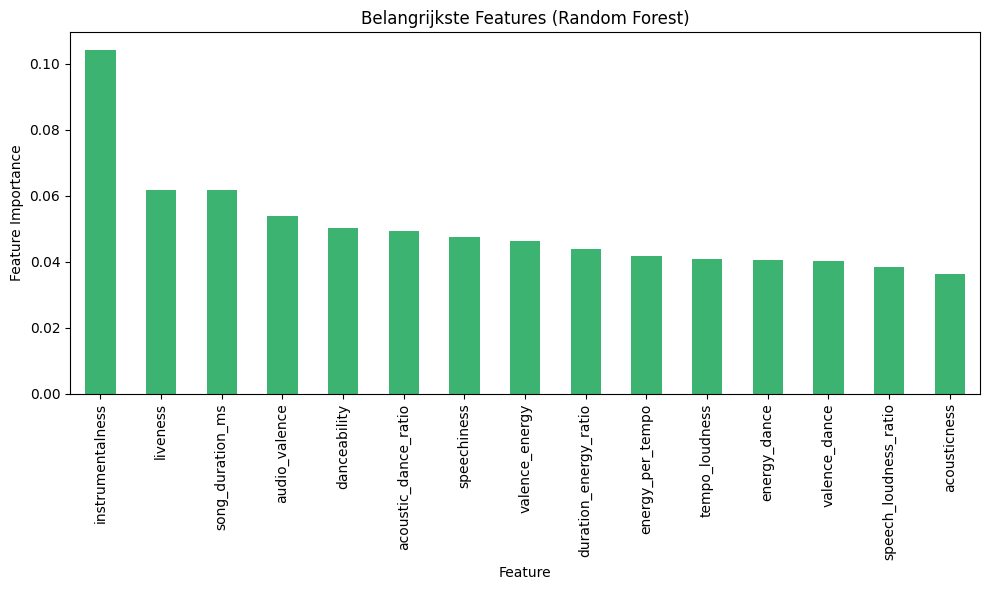

In [118]:
model = grid_search.best_estimator_.named_steps['model']
importances = model.feature_importances_

# Use helper to get feature names
preprocessor = grid_search.best_estimator_.named_steps['preprocess']
feature_names = get_feature_names_from_column_transformer(preprocessor)

# Create series and sort 
feat_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

#Plot top 15 belangrijke features

plt.figure(figsize=(10, 6))
feat_importance.head(15).plot(kind='bar', color='mediumseagreen')
plt.title("Belangrijkste Features (Random Forest)")
plt.ylabel("Feature Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()